In [1]:
%run ../widgets/config_check.py

sys:1: UserWarning: Your current version of bqplot (0.10.5) is older then the one used in tests (0.11). It is recommended to uprgade it.


In [2]:
# <api>
from __future__ import division
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook

# Introduction

Sampling methods allow to draw random samples from a given probability distribution. While special methods efficiently draw samples from common distribution, e.g. Gaussian, Poisson, ..., more general methods can draw samples from complicated, high-dimensional distributions. Common applications include:

* Random number generators in standard libraries employ sampling methods
* Bayesian models can often not be solved exactly as the normalization constant of the posterior cannot be computed in closed form and approximation or sampling methods are needed.

Samples are generally useful, as they can be used to approximate expectations. Consider the expectation of $f(x)$ under some distribution with density $p(x)$, i.e.
$$ \mathbb{E}_p[f] = \int f(x) p(x) dx $$
Then, if samples $x_1,\ldots,x_N$ from $p(x)$ are available the above expectation can be approximated by its empirical average over the samples
$$ \mathbb{E}_p[f] \approx \frac{1}{N} \sum_{i=1}^N f(x_i) .$$
This approximation is known as *Monte-Carlo estimation*.

Formally, Monte-Carlo estimation can be understood as integrating $f$ over the empirical measure of the samples:
$$ P_{N} = \frac{1}{N} \sum_{i=1}^N \delta_{x_i} $$
where $\delta_x(A) = \mathbb{1}_A(x)$ denotes the Dirac measure. In this sense, the Monte-Carlo estimate is an exact expectation $\mathbb{E}_{P_N}[f]$, but over the empirical measure $P_N$ instead of the actual measure with density $p(x)$.

Why is Monte-Carlo estimation so popular? Note that to solve the (possibly high-dimensional) integral $\int f(x) p(x) dx$ the most important points are where the integrand $f(x) p(x)$ take high values. Monte-Carlo sampling, by drawing from the distribution $p$, automatically focuses on point with high probability $p(x)$.

As any statistical procedure, the quality of the Monte-Carlo approximation $\hat{\mu} = \frac{1}{N} \sum_{i=1}^N f(x_i)$ for $\mathbb{E}_p[f] = \mu$ can be evaluated in terms of

* **bias**, i.e. $\mathbb{E}_p[\hat{\mu}] - \mu = 0$
* and **variance**, i.e. $\mathbb{V}ar_p[\hat{\mu}] = \mathbb{E}_p[(\hat{\mu} - \mu)^2]$

**Exercise**: Show that Monte-Carlo estimation is unbiased.

To compute the variance, denote the variance of a single sample $x$ as $\sigma^2 = \mathbb{E}_p[ (f(x) - \mu)^2 ] = \mathbb{V}ar_p[f]$. Then, since samples are independent, the variance of $\hat{\mu}$ is found to be
$$ \mathbb{V}ar_p[\frac{1}{N} \sum_{i=1}^N f(x_i)] = \frac{1}{N^2} \sum_{i=1}^N \mathbb{V}ar_p[f(x_i)] = \frac{1}{N} \sigma^2 $$
Interestingly, this variance scales as $\frac{1}{N}$ independent of the dimension of the space. Basically, this observation is the reason why Monte-Carlo integration is effective in high-dimensions.

Note: Also probabilities can be expressed as expectations, i.e.
$$ Pr(X \in A) = \int_A p(x) dx = \int \mathbb{1}_A(x) p(x) dx = \mathbb{E}_p[\mathbb{1}_A] $$
Basically, this is the reason that the histogram of the samples can be used to vizualize their underlying probability density.

## Standard distribution and inversion sampling

Most basic sampling methods assume that a source for uniform random numbers is available.

Let $U$ denote a uniform random variable, i.e. $u \in [0,1]$ and $P(U \leq u) = u$. Then, the distribution of $X = f(U)$ has the probability distribution
$$ P(X \leq x) = P(f(U) \leq x) = P(U \leq f^{-1}(x)) = f^{-1}(x)$$
assuming that $f$ is invertible.

Now, suppose we want to sample from some distribution with distribution function $P(X \leq x) = h(x)$. How do we have to choose $f$ such that $P(X \leq x)$ has the desired form?

From the above calculation, we see that $f = h^{-1}$ achieves the desired result. Thus, the following algorithm allows to draw samples from $X$ with distribution function $h(x)$:

* Draw a uniform random number $u \in [0,1]$
* $x = h^{-1}(u)$ is then a sample from the desired distribution

The next plot illustrates this method for the standard Gaussian distribution with density
$$ p(x) = \frac{1}{\sqrt{2 \pi}} e^{-\frac{1}{2} x^2} $$

In [3]:
# <api>
import numpy as np
from scipy.stats import norm

def phi(x):
    return norm.pdf(x)

def Phi(x):
    return norm.cdf(x)

def Phi_inv(x):
    return norm.ppf(x)

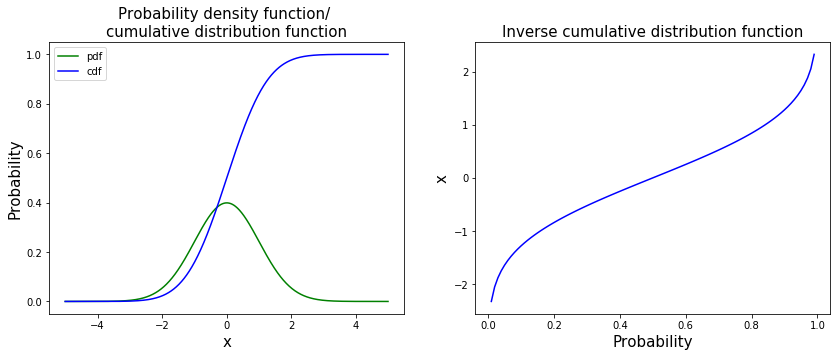

In [4]:
x = np.arange(-5, 5, 0.01)
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.plot(x, phi(x), 'g-')
plt.plot(x, Phi(x), 'b-')
plt.xlabel('x', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.legend(['pdf', 'cdf'], fontsize=10)
plt.title("Probability density function/ \ncumulative distribution function", fontsize=15);

u = np.arange(0, 1, 0.01)
plt.subplot(122)
plt.plot(u, Phi_inv(u), 'b-')
plt.xlabel('Probability', fontsize=15)
plt.ylabel('x', fontsize=15)
plt.title("Inverse cumulative distribution function", fontsize=15);
plt.show()

Before we show the sampling algorithm in action, we define a general interface for sampling methods

In [5]:
# <api>
class Sampling (object):
    """
    Abstract base class for all sampling methods.
    
    Subclasses need to implement self.sample()
    """
    def sample(self):
        pass
    
    def __str__(self):
        """
        Default is to show class
        """
        return str(self.__class__)
    
class InversionSampling (Sampling):
    def __init__(self, h_inv):
        self.h_inv = h_inv
        
    def sample(self):
        return self.h_inv(np.random.uniform())

and an interactive plotter to show our sampler in action

In [6]:
# <api>
import ipywidgets
from ipywidgets import widgets
from IPython import display

def show_sampling(sampling, plotter, N=1000, exp=True,  
                  f_exp=lambda x: np.power(x,2), true_exp=None, ):
    '''Show the histogramm and the expectaton for the given sampling method.
    
    Parameters
    ----------
    sampling(Sampling) : the given sampling method
    plotter(func) : the plotting function
    N(int) : the amount of samples
    exp(bool) : if True the expectation will be shown
    f_exp(func) : the function to calculate the expectation
    true_exp(None or float) : the true mean value of the target distribution (if it is given)
    '''
    
    def draw():        
        return [sampling.sample() for _ in range(N)]
    
    def calculate_expectation(samples):
        n = np.arange(1,N+1)
        tmp = f_exp(samples)         
        return(np.cumsum(tmp)/n)
    
    def show(redraw_check, num=100, bins=6): 
        # Check first, if we have to show the expectation
        if exp == True:
            plt.figure(figsize=(14, 5))
            plt.subplot(121)
            plotter(plt, samples[0][:num], bins)      
            plt.subplot(122)
            plt.plot(np.arange(1,N+1), calculate_expectation(samples), 'b-')        
            plt.axvline(num, color='red', alpha=0.7)
            if (true_exp is not None):
                plt.axhline(true_exp,  color='green', alpha=0.5) 
            
        else:  
            plotter(plt, samples[0][:num], bins)        
    
    def click(b):
        samples[0]=draw()
        check.value = not (check.value)
        
    # Draw the samples 
    samples = [draw()]
    
    # Create and show widgets
    check = widgets.Checkbox(value=False)
    button = widgets.Button(description="Redraw")        
    button.on_click(click)
    slider_samples = widgets.IntSlider(value=100, min=10, max=N, step=10, 
                                       description='Samples:', continuous_update=False)
    slider_bins = widgets.IntSlider(value=7, min=1, max=30, step=1, 
                                    description='Bins:', continuous_update=False)
    ui = widgets.HBox([button, slider_bins, slider_samples])        
    out = widgets.interactive_output(show, {'redraw_check': check, 'num' : slider_samples, 
                                            'bins' : slider_bins})
    display.display(ui, out)
    plt.show()

Finally, a demonstration of inversion sampling to draw samples from a standard Gaussian distribution:

In [7]:
# <api>
def gauss_hist (ax, data, bins=6):
    x = np.arange(-4,4,0.01)
    ax.hist(data, bins, normed=True)
    ax.plot(x, phi(x), 'r-', alpha=0.7)

In [8]:
sampling = InversionSampling(Phi_inv)
   
show_sampling(sampling, plotter=gauss_hist, f_exp=lambda x: np.power(x,2), true_exp=1.0)

Output()

Similarly, we can illustrate that expectations computed on the samples converge to the true value:

In [9]:
# <api>
def show_expectation (sampling, f):
    """
    Show how the expectation of f converges when increasing the number of samples
    """
    n = np.arange(1,2500)
    tmp = [f(sampling.sample()) for _ in n]
    
    Ef = np.cumsum(tmp)/n
    plt.plot(n, Ef, 'b-')

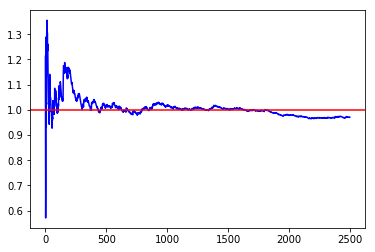

In [10]:
show_expectation(sampling, lambda x: x**2)
plt.axhline(1.0,  color='r'); # The true variance

**Exercise:** 

* Does your favorite library function, i.e. *numpy.random.normal*, use inversion sampling? If not, which algorithm is most used instead?
* How does the Box-Muller method work?